In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
NFL2016 = pd.read_csv("./NFLPlaybyPlay2009-2016(v3).csv", low_memory=False)

In [88]:
#Let's get an idea of what the data looks like
NFL2016.head(50)

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2009-09-10,2009091000,1,1,NaN,15:00,15,3600.0,0.0,TEN,...,NaN,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,NaN,NaN,2009
1,2009-09-10,2009091000,1,1,1.0,14:53,15,3593.0,7.0,PIT,...,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,2009-09-10,2009091000,1,1,2.0,14:16,15,3556.0,37.0,PIT,...,NaN,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,NaN,NaN,2009
3,2009-09-10,2009091000,1,1,3.0,13:35,14,3515.0,41.0,PIT,...,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2009-09-10,2009091000,1,1,4.0,13:27,14,3507.0,8.0,PIT,...,NaN,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,NaN,NaN,2009
5,2009-09-10,2009091000,2,1,1.0,13:16,14,3496.0,11.0,TEN,...,NaN,0.558929,0.441071,0.578453,0.421547,0.441071,-0.019524,NaN,NaN,2009
6,2009-09-10,2009091000,2,1,2.0,12:40,13,3460.0,36.0,TEN,...,0.163935,0.578453,0.421547,0.582881,0.417119,0.421547,-0.004427,-0.010456,0.006029,2009
7,2009-09-10,2009091000,2,1,3.0,12:11,13,3431.0,29.0,TEN,...,NaN,0.582881,0.417119,0.617544,0.382456,0.417119,-0.034663,NaN,NaN,2009
8,2009-09-10,2009091000,2,1,4.0,11:34,12,3394.0,37.0,TEN,...,NaN,0.617544,0.382456,0.591489,0.408511,0.382456,0.026054,NaN,NaN,2009
9,2009-09-10,2009091000,3,1,1.0,11:24,12,3384.0,10.0,TEN,...,0.541602,0.591489,0.408511,0.585405,0.414595,0.591489,-0.006084,-0.024526,0.018442,2009


We have a 102 columns.That's probably more than we will actually use but we should at least see what all we have to work with.

In [4]:
for key in NFL2016.keys():
    print(key)

Date
GameID
Drive
qtr
down
time
TimeUnder
TimeSecs
PlayTimeDiff
SideofField
yrdln
yrdline100
ydstogo
ydsnet
GoalToGo
FirstDown
posteam
DefensiveTeam
desc
PlayAttempted
Yards.Gained
sp
Touchdown
ExPointResult
TwoPointConv
DefTwoPoint
Safety
Onsidekick
PuntResult
PlayType
Passer
Passer_ID
PassAttempt
PassOutcome
PassLength
AirYards
YardsAfterCatch
QBHit
PassLocation
InterceptionThrown
Interceptor
Rusher
Rusher_ID
RushAttempt
RunLocation
RunGap
Receiver
Receiver_ID
Reception
ReturnResult
Returner
BlockingPlayer
Tackler1
Tackler2
FieldGoalResult
FieldGoalDistance
Fumble
RecFumbTeam
RecFumbPlayer
Sack
Challenge.Replay
ChalReplayResult
Accepted.Penalty
PenalizedTeam
PenaltyType
PenalizedPlayer
Penalty.Yards
PosTeamScore
DefTeamScore
ScoreDiff
AbsScoreDiff
HomeTeam
AwayTeam
Timeout_Indicator
Timeout_Team
posteam_timeouts_pre
HomeTimeouts_Remaining_Pre
AwayTimeouts_Remaining_Pre
HomeTimeouts_Remaining_Post
AwayTimeouts_Remaining_Post
No_Score_Prob
Opp_Field_Goal_Prob
Opp_Safety_Prob
Opp_Touchd

In [5]:
#Single Line for each game so I can just see the Teams that played
EachGame = NFL2016.groupby("GameID")
EachGameUsefull = EachGame[["HomeTeam", "AwayTeam", "Passer", "Season"]]
df = EachGameUsefull
df = df.last().reset_index()
# Make sure we have the same number of games for each team
df["HomeTeam"].value_counts()

TB     64
DEN    64
SF     64
KC     64
MIA    64
CLE    64
CHI    64
OAK    64
NO     64
SD     64
BAL    64
HOU    64
GB     64
IND    64
PIT    64
MIN    64
CIN    64
DET    64
TEN    64
ATL    64
ARI    64
WAS    64
NE     64
DAL    64
CAR    64
NYG    64
SEA    64
BUF    64
PHI    64
NYJ    64
JAC    57
STL    56
LA      8
JAX     7
Name: HomeTeam, dtype: int64

That's weird. Why are there 4 teams with numbers other than 64. Well, it's because the STL Rams moved to LA in 2016. Similarly, the Jaguars updated their abbreviation from JAC to JAX in 2016. We can easily fix those issues by replacing values. I chose to replace with the more modern version here to make the data easier to read. 

In [6]:
NFL2016 = NFL2016.replace("JAC", "JAX")
NFL2016 = NFL2016.replace("STL", "LA")

In [7]:
#Single Line for each game so I can just see the Teams that played
EachGame = NFL2016.groupby("GameID")
EachGameUsefull = EachGame[["HomeTeam", "AwayTeam", "Passer", "Season"]]
df = EachGameUsefull
df = df.last().reset_index()
# Make sure we have the same number of games for each team
df["HomeTeam"].value_counts()

TB     64
IND    64
SF     64
KC     64
MIA    64
CLE    64
CHI    64
OAK    64
NO     64
JAX    64
SD     64
BAL    64
HOU    64
GB     64
LA     64
MIN    64
PIT    64
DEN    64
CIN    64
DET    64
PHI    64
BUF    64
SEA    64
NYG    64
CAR    64
DAL    64
NE     64
WAS    64
ARI    64
ATL    64
TEN    64
NYJ    64
Name: HomeTeam, dtype: int64

OK, now we know that our data is reasonably clean at the highest level i.e. it has the right number of games for each team. But there is still one big thing that is missing from each row. We don't know who won the game! Let's see if we can figure that out.  

In [36]:
EachGame = NFL2016.groupby("GameID")
WonGame = EachGame[["HomeTeam", "AwayTeam", "ScoreDiff", "PlayTimeDiff", "Season"]]
df = WonGame
df = df.last().reset_index()
df

,GameID,HomeTeam,AwayTeam,ScoreDiff,PlayTimeDiff,Season
0,2009091000,PIT,TEN,0.0,0.0,2009
1,2009091300,ATL,MIA,12.0,38.0,2009
2,2009091301,BAL,KC,-15.0,6.0,2009
3,2009091302,CAR,PHI,26.0,34.0,2009
4,2009091303,CIN,DEN,-5.0,6.0,2009
...,...,...,...,...,...,...
2043,2017010111,WAS,NYG,-3.0,12.0,2016
2044,2017010112,DEN,OAK,18.0,39.0,2016
2045,2017010113,LA,ARI,-37.0,34.0,2016
2046,2017010114,SD,KC,-10.0,29.0,2016


Ok great, but what does that actually mean. Well, the easiest way to find out is to just go to the google machine and figure out who won the PIT/TEN, ATL/MIA, and BAL/KC games in 2009.

From this we can see that PIT/TEN was tied at the end of regulation (although the steelers did end up winning). For ATL/MIA ATL won by 12. For BAL/KC Baltimore won by 14. We can see some clear weirdness here. The Score difference doesn't appear to be sorted by who is the home/away team. 

In [10]:
EachGame = NFL2016.groupby("GameID")
WonGame = EachGame[["HomeTeam", "AwayTeam", "posteam", "ScoreDiff", "Season"]]
df = WonGame
df = df.last().reset_index()
df

,GameID,HomeTeam,AwayTeam,posteam,ScoreDiff,Season
0,2009091000,PIT,TEN,PIT,0.0,2009
1,2009091300,ATL,MIA,ATL,12.0,2009
2,2009091301,BAL,KC,KC,-15.0,2009
3,2009091302,CAR,PHI,PHI,26.0,2009
4,2009091303,CIN,DEN,CIN,-5.0,2009
...,...,...,...,...,...,...
2043,2017010111,WAS,NYG,WAS,-3.0,2016
2044,2017010112,DEN,OAK,DEN,18.0,2016
2045,2017010113,LA,ARI,LA,-37.0,2016
2046,2017010114,SD,KC,SD,-10.0,2016


From this we can see that the ScoreDiff is actually listed relative to which team has possession of the ball. So, for example, in the ATL/MIA game since the game ended with ATL in possession with a score diff of 12, ATL won by 12. However, in the BAL/KC game, since the game ended with KC in possession and a score of -15, KC LOST by 15

Now we need to get a table that has each gameID listed with the team that won the game. 

In [35]:
NFLWinners = df["GameID"].copy().to_frame()
winnersList = []
homeTeam = df["HomeTeam"]
posTeam = df["posteam"]
scoreDiff = df["ScoreDiff"]
for i in range(len(df["ScoreDiff"])):
    if scoreDiff[i] == 0:
        winnersList.append("Tie")
    elif scoreDiff[i] < 0:
        if homeTeam[i] == posTeam[i]:
            winnersList.append("Away")
        else:
            winnersList.append("Home")
    elif scoreDiff[i] > 0:
        if homeTeam[i] == posTeam[i]:
            winnersList.append("Home")
        else:
            winnersList.append("Away")
NFLWinners.insert(1, "WinningTeam", winnersList, True)
NFLWinners.head()

,GameID,WinningTeam
0,2009091000,Tie
1,2009091300,Home
2,2009091301,Home
3,2009091302,Away
4,2009091303,Away


So now we have a table that has all the game id's and the winners for that game. Let's clean up some more data. One of the arguments cited in Arkes' paper is that controlling time of possession is important. But we don't have a good column to see time of posession at different points in the game. So we should craft that column.

In [83]:
df = NFL2016.copy()
EachGame = NFL2016.groupby(["GameID", "posteam"])
TimeOfPossession = EachGame[["HomeTeam", "AwayTeam", "posteam", "PlayTimeDiff", "Season"]]
for group_key, group_value in TimeOfPossession:
    group = TimeOfPossession.get_group(group_key)
    df.loc[group.index, "CumulativeTOP"] = group.cumsum()["PlayTimeDiff"]

Ok, so now we have our dataframe that tracks the cumulative time of possession so that we can use that. 

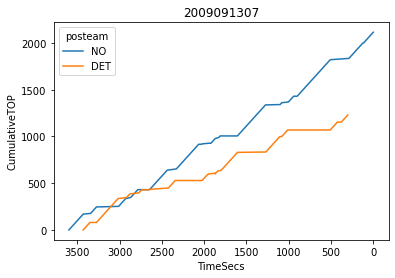

In [104]:
TimeOfPossessionTracker = df[["GameID","HomeTeam", "AwayTeam", "posteam", "TimeSecs", "CumulativeTOP", "Season"]]
TimeOfPossessionTracker = TimeOfPossessionTracker.dropna()
fig = plt.figure()
for game in TimeOfPossessionTracker.GameID.unique()[2:3]:
    g = sns.lineplot(
        data=TimeOfPossessionTracker[TimeOfPossessionTracker["GameID"] == game],
        x="TimeSecs",
        y ="CumulativeTOP",
        hue = "posteam"
    )
    g.set(title=game)
    g.invert_xaxis()

In [91]:
NFLGeneral = NFL2016[["HomeTeam", "AwayTeam", "GameID", "Drive", "qtr", "down", "yrdline100", 
                     "FirstDown", "Yards.Gained", "Touchdown", "PlayType"]]
NFLGeneral.head()

,HomeTeam,AwayTeam,GameID,Drive,qtr,down,yrdline100,FirstDown,Yards.Gained,Touchdown,PlayType
0,PIT,TEN,2009091000,1,1,NaN,30.0,NaN,39,0,Kickoff
1,PIT,TEN,2009091000,1,1,1.0,58.0,0.0,5,0,Pass
2,PIT,TEN,2009091000,1,1,2.0,53.0,0.0,-3,0,Run
3,PIT,TEN,2009091000,1,1,3.0,56.0,0.0,0,0,Pass
4,PIT,TEN,2009091000,1,1,4.0,56.0,1.0,0,0,Punt


In [8]:
NFLPassing = NFL2016[["HomeTeam", "AwayTeam", "Passer", "Receiver", "AirYards", "YardsAfterCatch", "PassLocation", 
                      "InterceptionThrown", "QBHit"]]
NFLPassing = NFLPassing.dropna()
NFLPassing.head()

,HomeTeam,AwayTeam,Passer,Receiver,AirYards,YardsAfterCatch,PassLocation,InterceptionThrown,QBHit
1,PIT,TEN,B.Roethlisberger,H.Ward,-3,8,left,0,0
3,PIT,TEN,B.Roethlisberger,M.Wallace,34,0,right,0,0
6,PIT,TEN,K.Collins,A.Hall,3,1,left,0,0
9,PIT,TEN,B.Roethlisberger,M.Wallace,-2,5,right,0,0
10,PIT,TEN,B.Roethlisberger,S.Holmes,-1,11,left,0,0


In [9]:
NFLRushing = NFL2016[["HomeTeam", "AwayTeam", "Rusher", "RunLocation", "RunGap"]]
NFLRushing = NFLRushing.dropna()
NFLRushing.head()

,HomeTeam,AwayTeam,Rusher,RunLocation,RunGap
2,PIT,TEN,W.Parker,right,end
7,PIT,TEN,C.Johnson,left,end
11,PIT,TEN,W.Parker,right,guard
15,PIT,TEN,C.Johnson,right,end
17,PIT,TEN,C.Johnson,left,end


In [18]:
NFLTeams = NFL2016.HomeTeam.unique()
print(NFLTeams, "is of length", len(NFLTeams))

['PIT' 'CLE' 'NO' 'TB' 'HOU' 'IND' 'CIN' 'CAR' 'BAL' 'ATL' 'ARI' 'SEA'
 'NYG' 'GB' 'NE' 'OAK' 'DET' 'WAS' 'TEN' 'PHI' 'NYJ' 'KC' 'JAC' 'SF' 'BUF'
 'SD' 'DEN' 'CHI' 'DAL' 'MIA' 'MIN' 'STL' 'LA' 'JAX'] is of length 34


The Above is weird because it says we have 34 teams, but the NFL only has 32 teams. This is likely due to teams moving, such as STL and LA are both listed above but the STL Rams became the LA Rams in 2016. 

In [28]:
LATeams = NFLPassing[NFLPassing["HomeTeam"] == "LA"]
LATeams.Passer.unique()

array(['C.Keenum', 'R.Wilson', 'T.Taylor', 'E.Manning', 'C.Newton',
       'J.Goff', 'R.Tannehill', 'M.Ryan', 'M.Schaub', 'C.Kaepernick',
       'C.Palmer', 'J.Hekker', 'S.Mannion', 'D.Stanton'], dtype=object)